# Dog Breed Identification
Dog breed identification model using Tensorflow Keras. The dataset consists of 10k plus images of dogs belonging to 120 different breeds. Our work performed here is to train a model than can classify an image to its dog breed.

This Jupyter Notebook is written on Kaggle so the directories are related to kaggle's directory structure. You can access dataset [here](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

In [2]:
print(tf.__version__)
print(hub.__version__)

if tf.config.list_physical_devices('GPU'):
    print('GPU Available!')
else:
    print('GPU Unavailable')

2.6.4
0.12.0
GPU Available!


2023-02-16 16:08:10.241653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:08:10.361070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:08:10.362208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Labels of Dataset
Reading the labels of the dataset to start working with them. The labels file is in `dog-breed-identification/labels.csv`

In [3]:
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


### Frequency Distribution graph of each breed with its corresponding input
We are now ploting a frequency distribution graph of the dog breeds and the number of dogs belonging to it to get a visualised view of what we are dealing with.

<AxesSubplot:>

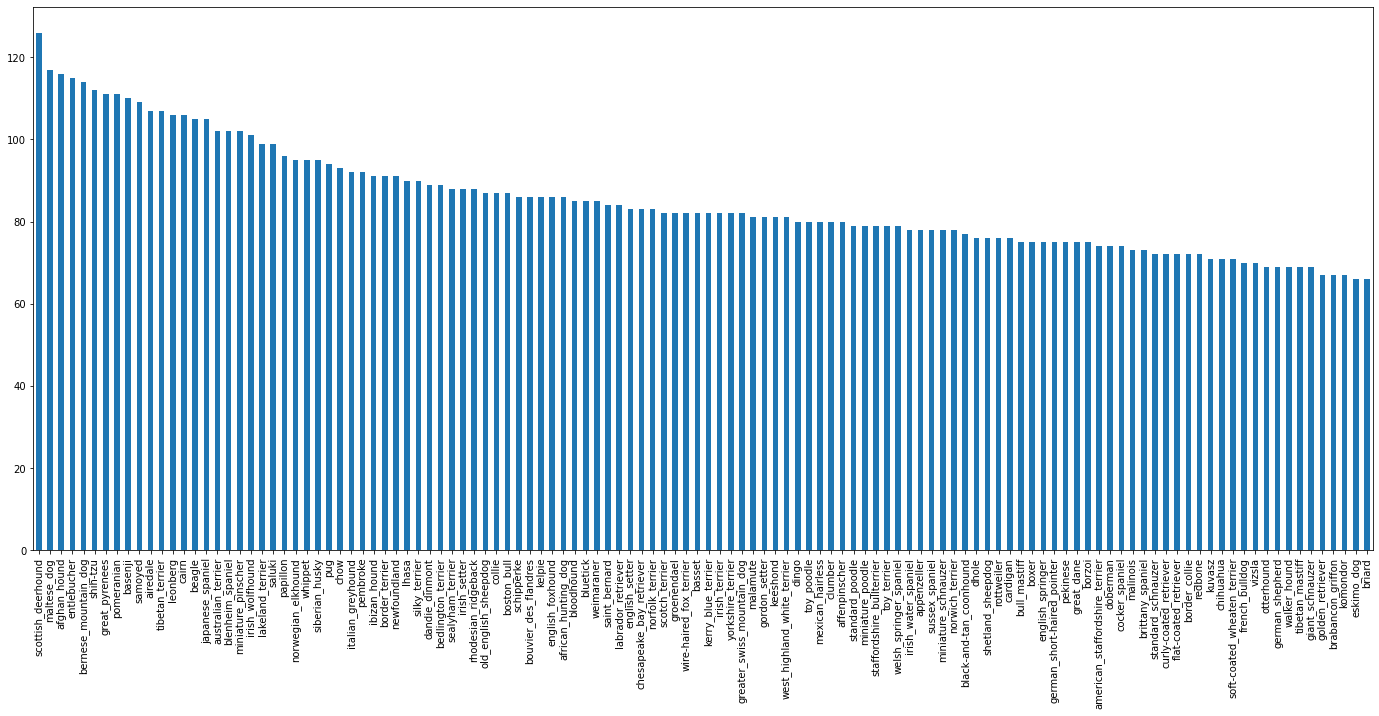

In [4]:
labels['breed'].value_counts().plot.bar(figsize=(24,10))

### Filtering out more important aspects of dataset
Now we will firstly create file paths from the labels. Then we will also get unique breeds list which should be equal to 120 and lastly we will booleanise our train images with breeds.

In [5]:
img_names_list = [
    f'/kaggle/input/dog-breed-identification/train/{name}.jpg'
    for name in labels['id']
]

len(img_names_list) == len(labels['id'])

True

In [6]:
breeds_arr = labels['breed'].to_numpy()
unique_breeds = np.unique(breeds_arr)

In [7]:
bool_breeds = [
    breed == unique_breeds
    for breed in breeds_arr
]
len(bool_breeds)

10222

In [8]:
print(breeds_arr[0])
print(bool_breeds[0].astype(int))

boston_bull
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Train and Validation sets
Now here we are going to use only 1000 images for the initial training and testing of model which we will split in 4/1 ratio. Where 800 images are going to be used for training of the model and remaining 200 images will be used for the testing of the model.

In [9]:
NUM_IMAGES = 1000
x = img_names_list
y = bool_breeds

x_train, x_val, y_train, y_val = train_test_split(
    x[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size = 0.2,
    random_state = 42
)

### Image Processing
We are going to work with Tensorflow Keras model, for it work it needs images to be processed into tensors. We will reduce its size to only 224 of ratio 1 and change the color channel range between 0 and 1. The work will be performed by a function `preprocess`

In [10]:
img = imread(img_names_list[0])
tf.constant(img[:2])

2023-02-16 16:08:12.355614: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 16:08:12.356121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:08:12.357091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:08:12.357796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[109,  46,   0],
        [153,  91,  40],
        [180, 120,  68],
        ...,
        [176, 144,  71],
        [189, 157,  84],
        [214, 182, 109]],

       [[153,  92,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 135,  58],
        [171, 139,  62],
        [188, 156,  79]]], dtype=uint8)>

In [11]:
IMG_SIZE = 224

def preprocess(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])
    return image

## Converting data into batches
The model needs to be trained on the base of data batches, so we will devide our images into small batches of 32 images. The data batches will be generated on a shuffled dataset for increased efficiency. On these batches of data we will train and test our model.

In [12]:
def get_img_label(img_path, label):
    image = preprocess(img_path)
    return image, label

In [13]:
(preprocess(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [14]:
BATCH_SIZE = 32

def data_to_batches(
    x,
    y = None,
    batch_size = BATCH_SIZE,
    valid_data = False,
    test_data = False
):
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(preprocess).batch(BATCH_SIZE)
    
    elif valid_data:
        print("Creating validating data batches...")
        data = tf.data.Dataset.from_tensor_slices((
            tf.constant(x),
            tf.constant(y)
        ))
        data_batch = data.map(get_img_label).batch(BATCH_SIZE)
    
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((
            tf.constant(x),
            tf.constant(y)
        ))
        data = data.shuffle(buffer_size = len(x)) 
        data_batch = data.map(get_img_label).batch(BATCH_SIZE)
        
    return data_batch 

In [15]:
train_data = data_to_batches(x_train, y_train)
val_data = data_to_batches(x_val, y_val, valid_data = True)

Creating training data batches...
Creating validating data batches...


In [16]:
train_data.element_spec,
val_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

## Visualizing Data Batches
`show_25_images` is going to be used to get a visualisation of images in any data batch.

In [17]:
def show_25_images(img, label):
    plt.figure(figsize = (15, 15))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(img[i])
        plt.title(unique_breeds[label[i].argmax()])
        plt.axis('off')

2023-02-16 16:08:15.630374: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


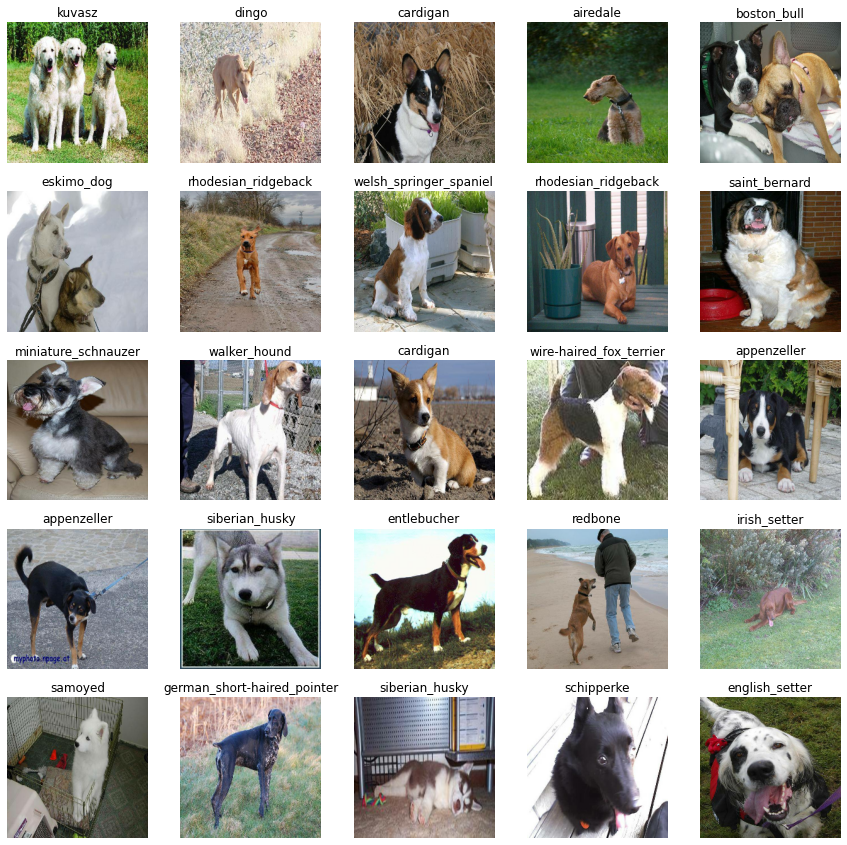

In [18]:
train_imgs, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_imgs, train_labels)

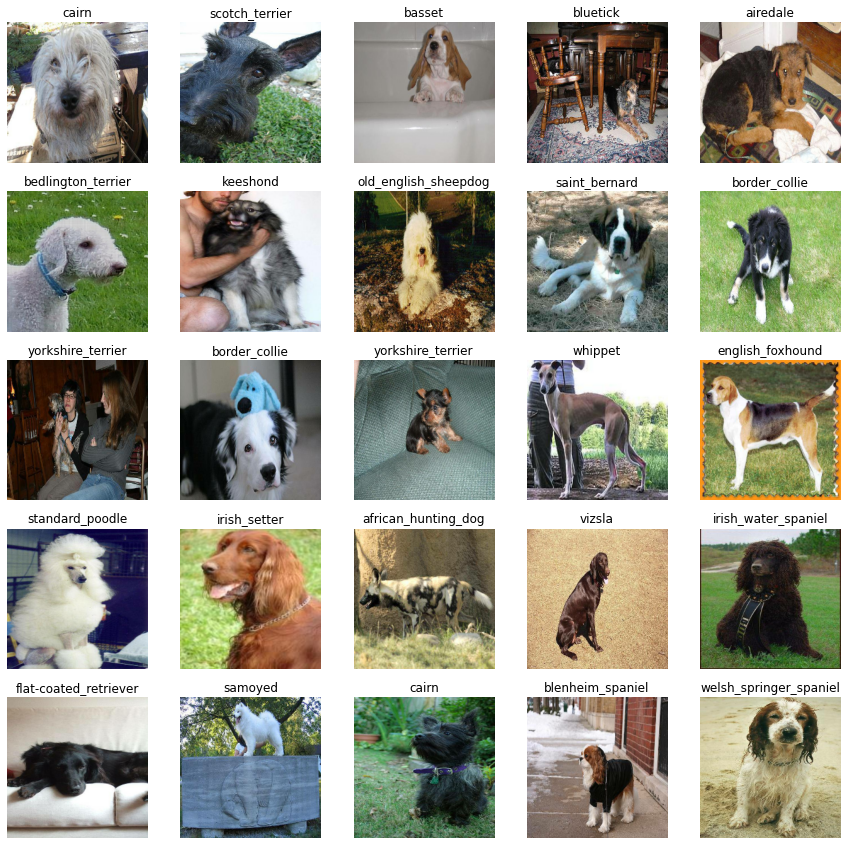

In [19]:
val_images, val_labels = next(val_data.as_numpy_iterator()) #We convert batches to numpy arrays and then we assign it
show_25_images(val_images, val_labels)

## Building Model
Model builing process includes creating callback functions and model training over a imagenet model.

In [20]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [21]:
def create_model(
    input_shape = INPUT_SHAPE,
    output_shape = OUTPUT_SHAPE,
    model_url = MODEL_URL
):
    print(f'Building Model with: {model_url}')
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units = output_shape, activation = 'softmax')
    ]) 
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )
    model.build(input_shape)
    
    return model

In [22]:
model = create_model()
model.summary()

Building Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating Callbacks

In [23]:
%load_ext tensorboard
os.makedirs('/kaggle/working/logs')

In [24]:
def create_tensorboard_callback():
    logdir = os.path.join(
        '/kaggle/working/logs',
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )
    return tf.keras.callbacks.TensorBoard(logdir)

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [26]:
NUM_EPOCHS = 100

def train_model():
    model = create_model()
    tensorboard = create_tensorboard_callback()
    
    model.fit(
        x = train_data,
        epochs = NUM_EPOCHS,
        validation_data = val_data,
        validation_freq = 1,
        callbacks = [
            tensorboard,
            early_stopping
        ]
    )
    
    return model

model = train_model()

Building Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


2023-02-16 16:08:23.787959: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-16 16:08:23.788000: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-16 16:08:23.789923: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-02-16 16:08:24.011525: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-16 16:08:24.011714: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/100


2023-02-16 16:08:28.401157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/25 [>.............................] - ETA: 4:00 - loss: 5.5723 - accuracy: 0.0000e+00

2023-02-16 16:08:34.521503: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-16 16:08:34.521585: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/25 [=>............................] - ETA: 14s - loss: 5.5737 - accuracy: 0.0000e+00 

2023-02-16 16:08:34.863056: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-16 16:08:34.863867: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-02-16 16:08:35.011964: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 285 callback api events and 282 activity events. 
2023-02-16 16:08:35.027270: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-16 16:08:35.048215: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/20230216-160823/train/plugins/profile/2023_02_16_16_08_35

2023-02-16 16:08:35.056448: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /kaggle/working/logs/20230216-160823/train/plugins/profile/2023_02_16_16_08_35/11016ba9104a.trace.json.gz


 3/25 [==>...........................] - ETA: 10s - loss: 5.6289 - accuracy: 0.0000e+00

2023-02-16 16:08:35.096308: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/20230216-160823/train/plugins/profile/2023_02_16_16_08_35

2023-02-16 16:08:35.103209: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /kaggle/working/logs/20230216-160823/train/plugins/profile/2023_02_16_16_08_35/11016ba9104a.memory_profile.json.gz
2023-02-16 16:08:35.104331: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /kaggle/working/logs/20230216-160823/train/plugins/profile/2023_02_16_16_08_35
Dumped tool data for xplane.pb to /kaggle/working/logs/20230216-160823/train/plugins/profile/2023_02_16_16_08_35/11016ba9104a.xplane.pb
Dumped tool data for overview_page.pb to /kaggle/working/logs/20230216-160823/train/plugins/profile/2023_02_16_16_08_35/11016ba9104a.overview_page.pb
Dumped tool data for input_pipeline.pb to /kaggle/working/logs/20230216-160823/tr

25/25 [==============================] - 17s 308ms/step - loss: 4.5447 - accuracy: 0.0875 - val_loss: 3.4036 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 2s 90ms/step - loss: 1.5894 - accuracy: 0.6913 - val_loss: 2.2022 - val_accuracy: 0.4750
Epoch 3/100
25/25 [==============================] - 3s 133ms/step - loss: 0.5375 - accuracy: 0.9362 - val_loss: 1.7279 - val_accuracy: 0.5700
Epoch 4/100
25/25 [==============================] - 2s 95ms/step - loss: 0.2431 - accuracy: 0.9912 - val_loss: 1.5588 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 2s 96ms/step - loss: 0.1437 - accuracy: 0.9975 - val_loss: 1.4699 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 2s 89ms/step - loss: 0.0978 - accuracy: 1.0000 - val_loss: 1.4293 - val_accuracy: 0.6250
Epoch 7/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0742 - accuracy: 1.0000 - val_loss: 1.3935 - val_accuracy: 0.6300
Epoch 8/100
25/

In [27]:
%tensorboard --logdir "/kaggle/working/logs"

# Making Predictions using our trained model

In [28]:
pred = model.predict(val_data, verbose = 1)
pred

7/7 [==============================] - 4s 62ms/step


array([[2.43359013e-03, 2.16854198e-04, 1.04068767e-03, ...,
        2.22864124e-04, 9.15585406e-05, 4.08843765e-03],
       [4.31455625e-03, 2.94368918e-04, 1.81258004e-02, ...,
        2.55269057e-04, 8.50272458e-03, 2.42406401e-04],
       [3.17753329e-05, 2.81488974e-06, 1.10385045e-05, ...,
        9.84244070e-06, 8.19099223e-05, 1.42217687e-04],
       ...,
       [5.25937794e-05, 1.41648445e-04, 6.74731127e-05, ...,
        1.40946388e-04, 2.89477088e-04, 1.03464932e-04],
       [6.35333220e-03, 9.21164028e-05, 1.87432233e-04, ...,
        3.14271056e-05, 1.04380466e-04, 3.54676368e-03],
       [3.51383490e-03, 2.99309086e-05, 4.18444833e-04, ...,
        8.38375930e-03, 2.36598519e-03, 4.52289300e-04]], dtype=float32)

In [ ]:
pred.shape
np.sum(pred)
pred[0]
# pred[0].argmax()
# unique_breeds[26]

In [30]:
# first prediction
index = 0

print(pred[0])
print(f'Max value (probabilty prediction): {np.max(pred[index])}')
print(f"Sum: {np.sum(pred[index])}")
print(f"Max Index: {np.argmax(pred[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(pred[index])]}")

[2.43359013e-03 2.16854198e-04 1.04068767e-03 1.39160955e-04
 1.83105833e-04 1.01386104e-04 6.51310477e-03 3.60347942e-04
 2.03878139e-04 4.56494698e-03 1.81839254e-03 2.45572446e-04
 2.59697961e-04 5.96035505e-04 2.07292862e-04 2.61781970e-03
 1.01421007e-04 1.71038166e-01 1.18705771e-04 8.19260458e-05
 5.12214610e-04 1.13390898e-03 5.32469603e-05 6.39190606e-04
 2.00578390e-04 7.69738574e-04 9.96890441e-02 6.87601394e-04
 6.35006698e-04 5.33491489e-04 1.42551248e-03 1.32823014e-03
 2.61587556e-03 6.45677501e-05 1.03593025e-04 3.16534378e-02
 4.07512125e-05 1.01886981e-03 5.00986585e-04 5.75396058e-04
 1.35310309e-03 1.53042965e-05 1.71721913e-04 8.16855609e-05
 1.37517054e-04 1.68730694e-04 1.21896992e-04 8.34445935e-04
 8.48574855e-04 9.63744475e-04 8.57565756e-05 2.05949211e-04
 5.88871248e-04 8.79866129e-05 1.62448746e-03 1.06487161e-04
 7.92540261e-04 1.14143891e-02 5.57300868e-04 1.10891946e-01
 1.34654972e-03 4.05621904e-05 3.93951684e-03 1.49246298e-05
 1.50635059e-03 2.486379

In [31]:
def get_pred_label(pred_prob):
     return unique_breeds[np.argmax(pred_prob)]

In [32]:
pred_label = get_pred_label(pred[0])
pred_label

'border_terrier'

In [ ]:
def unbatch(data):
    images = []
    labels = []
    
    for img, label in data.unbatch().as_numpy_iterator():
        images.append(img)
        labels.append(unique_breeds[np.argmax(label)])
    
    return images, labels

validation_images, validation_labels = unbatch(val_data)

In [ ]:
get_pred_label(validation_labels[0])

if get_pred_label(pred[0]) == get_pred_label(validation_labels[1]):
    print(f"{get_pred_label(pred[0])} is corrected predicted" )
else:
    print(f"{get_pred_label(pred[0])} is false predicted while true label is {get_pred_label(validation_labels[1])}" )

## Prediction Visualization

In [ ]:
def plot_pred(
    pred_prob,
    label,
    img,
    n
):
    pred_prob, true_label, img = pred_prob[n], label[n], img[n]
    pred_label = get_pred_label(pred_prob)
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
    title_object = plt.title('{} {:2.0f}%--{}'.format(
        pred_label,
        np.max(pred_prob) * 100,
        true_label
    ), color = 'green')
    
    if pred_label != true_label:
        plt.setp(title_object, color = 'r')
    else: pass
    

In [ ]:
plot_pred(pred, validation_labels, validation_images, 1)
val_labels

In [ ]:
def plot_pred_conf(
    pred_probs,
    labels,
    n
):
    pred_prob, true_label = pred_probs[n], labels[n]
    pred_label = get_pred_label(pred_prob)
    
    indexes_10 = pred_prob.argsort()[-10:][::-1]
    values_10 = pred_prob[indexes_10]
    labels_10 = unique_breeds[indexes_10]
    
    plot = plt.bar(
        np.arange(len(indexes_10)),
        values_10,
        color = 'grey'
    )
    plt.xticks(
        np.arange(len(labels_10)),
        labels = labels_10,
        rotation = 'vertical'
    )
    
    if np.isin(unique_breeds[true_label], labels_10):
        plot[
            np.argmax(unique_breeds[true_label] == labels_10)
        ].set_color('green')
    else: pass

In [ ]:
plot_pred_conf(pred, val_labels, 6)

In [ ]:
i_multiplier = 10
num_rows = 3
num_col = 3
num_images = num_rows * num_col

plt.figure(figsize = (10 * num_col, 5 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_col, 2 * i + 1)
    plot_pred(
        pred,
        validation_labels,
        validation_images,
        i+i_multiplier
    )
    plt.subplot(num_rows, 2 * num_col, 2 * i + 1)
    plot_pred_conf(
        pred,
        val_labels,
        i + i_multiplier
    )
    
plt.tight_layout(h_pad = 1.0)
plt.show()

In [ ]:
plt.figure(figsize =  (10 * num_col, 5 * num_rows))
plt.subplot(num_rows, 2 * num_col, 2 * i + 1)
plot_pred(
    pred,
    validation_labels,
    validation_images,
    i + i_multiplier
)
plt.subplot(num_rows, 2 * num_col, 2 * i + 1)
plot_pred_conf(
    pred,
    val_labels,
    i + i_multiplier
)

In [ ]:
def save_model(model, suffix = None):
    model_dir = os.path.join("/kaggle/model", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = model_dir + '-' + suffix + '.h5'
    print(f"Saving model to :{model_path}...")
    model.save(model_path)
    return model_path

In [ ]:
def load_model(model_path):
    print(f"Loading save model from :{model_path}...")
    model = tf.keras.models.load_model(model_path, custom_objects = {"KerasLayer":hub.KerasLayer})
    return model

In [ ]:
save_model(model, suffix = "1000-images-mobilenetV2-Adam")

In [ ]:
model = load_model('/kaggle/model/20230209-09421675935753-1000-images-mobilenetV2-Adam.h5')